In [1]:
import os
import glob

BASE_DIR = "/content/drive/MyDrive/figshare"

mat_files = glob.glob(os.path.join(BASE_DIR, "**", "*.mat"), recursive=True)
print("Number of .mat files found:", len(mat_files))
print("First 5:", mat_files[:5])


Number of .mat files found: 3065
First 5: ['/content/drive/MyDrive/figshare/dataset/cvind.mat', '/content/drive/MyDrive/figshare/dataset/data/2946.mat', '/content/drive/MyDrive/figshare/dataset/data/2907.mat', '/content/drive/MyDrive/figshare/dataset/data/2858.mat', '/content/drive/MyDrive/figshare/dataset/data/2886.mat']


In [2]:
MAT_ROOT = "/content/drive/MyDrive/figshare/dataset/data"


In [3]:
import os

MAT_ROOT = "/content/drive/MyDrive/figshare/dataset/data"  # adjust if needed
YOLO_ROOT = "/content/figshare_yolo"

IMG_ALL_DIR   = os.path.join(YOLO_ROOT, "images_all")
LABEL_ALL_DIR = os.path.join(YOLO_ROOT, "labels_all")

os.makedirs(IMG_ALL_DIR, exist_ok=True)
os.makedirs(LABEL_ALL_DIR, exist_ok=True)

print("MAT_ROOT:", MAT_ROOT)
print("YOLO_ROOT:", YOLO_ROOT)


MAT_ROOT: /content/drive/MyDrive/figshare/dataset/data
YOLO_ROOT: /content/figshare_yolo


In [6]:
import h5py
import numpy as np

def load_mat_v7_3(path):
    with h5py.File(path, 'r') as f:
        cjdata = f['cjdata']

        # Extract fields
        image = np.array(cjdata['image']).T      # transpose needed (HDF5 stores transposed)
        mask  = np.array(cjdata['tumorMask']).T
        label = int(np.array(cjdata['label'])[0][0])
        pid   = int(np.array(cjdata['PID'])[0][0])

        return image, mask, label, pid


In [7]:
test_file = "/content/drive/MyDrive/figshare/dataset/data/1.mat"

image, mask, label, pid = load_mat_v7_3(test_file)

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)
print("Label:", label)
print("PID:", pid)


Image shape: (512, 512)
Mask shape: (512, 512)
Label: 1
PID: 49


In [8]:
import os
import cv2
import h5py
import numpy as np
from tqdm import tqdm
from scipy.ndimage import label as cc_label

MAT_ROOT = "/content/drive/MyDrive/figshare/dataset/data"
YOLO_ROOT = "/content/figshare_yolo"

IMG_ALL_DIR   = os.path.join(YOLO_ROOT, "images_all")
LABEL_ALL_DIR = os.path.join(YOLO_ROOT, "labels_all")

os.makedirs(IMG_ALL_DIR, exist_ok=True)
os.makedirs(LABEL_ALL_DIR, exist_ok=True)

def load_mat_v7_3(path):
    with h5py.File(path, 'r') as f:
        cj = f['cjdata']
        image = np.array(cj['image']).T
        mask = np.array(cj['tumorMask']).T
        label = int(np.array(cj['label'])[0][0])
        return image, mask, label

mat_files = [f for f in os.listdir(MAT_ROOT) if f.endswith(".mat")]

for fname in tqdm(mat_files):
    path = os.path.join(MAT_ROOT, fname)

    image, mask, label_val = load_mat_v7_3(path)

    H, W = image.shape
    base = os.path.splitext(fname)[0]
    out_img = os.path.join(IMG_ALL_DIR, base + ".jpg")

    # Save image
    img_uint8 = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(out_img, img_rgb)

    # YOLO label generation
    bin_mask = (mask > 0).astype(np.uint8)

    if bin_mask.sum() == 0:
        # no tumor → no label file
        continue

    labeled, num_cc = cc_label(bin_mask)
    lines = []

    for cc_id in range(1, num_cc+1):
        ys, xs = np.where(labeled == cc_id)
        if len(xs) < 20:
            continue

        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

        x_center = (x_min + x_max) / 2 / W
        y_center = (y_min + y_max) / 2 / H
        bw = (x_max - x_min) / W
        bh = (y_max - y_min) / H

        # single class: tumor = 0
        lines.append(f"0 {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")

    if len(lines) > 0:
        with open(os.path.join(LABEL_ALL_DIR, base + ".txt"), "w") as f:
            f.write("\n".join(lines))


100%|██████████| 3064/3064 [01:53<00:00, 26.94it/s]


In [9]:
import os, glob, shutil, random

YOLO_ROOT = "/content/figshare_yolo"
IMG_ALL_DIR   = os.path.join(YOLO_ROOT, "images_all")
LABEL_ALL_DIR = os.path.join(YOLO_ROOT, "labels_all")

# List all JPG images
all_images = sorted(glob.glob(os.path.join(IMG_ALL_DIR, "*.jpg")))
print("Total images saved:", len(all_images))

# Keep only images that have a label file (tumor present)
labeled_images = []
for img_path in all_images:
    base = os.path.splitext(os.path.basename(img_path))[0]
    label_path = os.path.join(LABEL_ALL_DIR, base + ".txt")
    if os.path.exists(label_path):
        labeled_images.append(img_path)

print("Images with tumor labels:", len(labeled_images))

# Shuffle + split 80/20
random.seed(42)
random.shuffle(labeled_images)

split_idx = int(0.8 * len(labeled_images))
train_imgs = labeled_images[:split_idx]
val_imgs   = labeled_images[split_idx:]

print("Train images:", len(train_imgs))
print("Val images:", len(val_imgs))

def copy_split(img_list, split):
    img_out_dir   = os.path.join(YOLO_ROOT, "images", split)
    label_out_dir = os.path.join(YOLO_ROOT, "labels", split)
    os.makedirs(img_out_dir, exist_ok=True)
    os.makedirs(label_out_dir, exist_ok=True)

    for img_path in img_list:
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(LABEL_ALL_DIR, base + ".txt")

        shutil.copy2(img_path,  os.path.join(img_out_dir,   base + ".jpg"))
        shutil.copy2(label_path, os.path.join(label_out_dir, base + ".txt"))

copy_split(train_imgs, "train")
copy_split(val_imgs, "val")


Total images saved: 3064
Images with tumor labels: 3064
Train images: 2451
Val images: 613


In [10]:
brain_yaml = """
path: /content/figshare_yolo

train: images/train
val: images/val

names:
  0: tumor
"""

yaml_path = os.path.join(YOLO_ROOT, "brain.yaml")
with open(yaml_path, "w") as f:
    f.write(brain_yaml)

print("Created:", yaml_path)


Created: /content/figshare_yolo/brain.yaml


In [11]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.5 MB/s eta 0:00:00


In [12]:
from ultralytics import YOLO

# Start from a small pretrained YOLO model
model = YOLO("yolov8n.pt")   # you can try 'yolov8s.pt' later for higher accuracy

results = model.train(
    data="/content/figshare_yolo/brain.yaml",
    epochs=50,
    imgsz=512,      # Figshare images are 512x512
    batch=8,
    patience=10,    # early stopping if val doesn't improve
    workers=2
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/figshare_yolo/brain.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, ker

In [13]:
best_model = YOLO("runs/detect/train/weights/best.pt")

val_results = best_model.val(
    data="/content/figshare_yolo/brain.yaml",
    imgsz=512,
    batch=8
)


Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 801.9±341.7 MB/s, size: 50.2 KB)
val: Scanning /content/figshare_yolo/labels/val.cache... 613 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 613/613 886.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 77/77 8.3it/s 9.3s
                   all        613        613      0.886      0.838      0.917      0.624
Speed: 1.5ms preprocess, 4.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/runs/detect/val


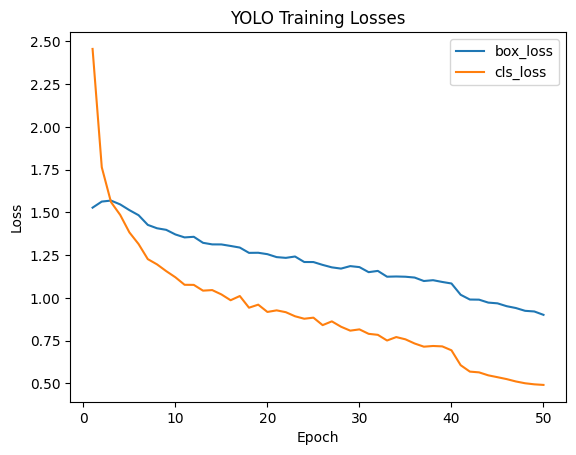

<Figure size 640x480 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("runs/detect/train/results.csv")
plt.figure()
plt.plot(df['epoch'], df['train/box_loss'], label='box_loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='cls_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('YOLO Training Losses')
plt.show()
plt.savefig("train_losses_yolo.png")


In [14]:
pred_results = best_model.predict(
    source="/content/figshare_yolo/images/val",
    imgsz=512,
    conf=0.25,
    save=True   # saves images with drawn boxes
)

# saved to: runs/detect/predict/ by default



image 1/613 /content/figshare_yolo/images/val/10.jpg: 512x512 1 tumor, 9.4ms
image 2/613 /content/figshare_yolo/images/val/100.jpg: 512x512 1 tumor, 11.2ms
image 3/613 /content/figshare_yolo/images/val/1003.jpg: 512x512 1 tumor, 13.3ms
image 4/613 /content/figshare_yolo/images/val/1005.jpg: 512x512 1 tumor, 6.5ms
image 5/613 /content/figshare_yolo/images/val/101.jpg: 512x512 2 tumors, 6.7ms
image 6/613 /content/figshare_yolo/images/val/1010.jpg: 512x512 1 tumor, 6.2ms
image 7/613 /content/figshare_yolo/images/val/1018.jpg: 512x512 1 tumor, 6.2ms
image 8/613 /content/figshare_yolo/images/val/1021.jpg: 512x512 1 tumor, 6.3ms
image 9/613 /content/figshare_yolo/images/val/1024.jpg: 512x512 1 tumor, 6.6ms
image 10/613 /content/figshare_yolo/images/val/1027.jpg: 512x512 1 tumor, 6.7ms
image 11/613 /content/figshare_yolo/images/val/1032.jpg: 512x512 1 tumor, 6.4ms
image 12/613 /content/figshare_yolo/images/val/1033.jpg: 512x512 1 tumor, 6.2ms
image 13/613 /content/figshare_yolo/images/val/10

In [19]:
import glob
from IPython.display import Image, display

pred_dir = "runs/detect/val_pred"
pred_imgs = sorted(glob.glob(pred_dir + "/*.jpg"))[:10]  # first 10 images

for img_path in pred_imgs:
    display(Image(filename=img_path))



image 1/1 /content/figshare_yolo/images/val/10.jpg: 512x512 1 tumor, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/detect/single_pred


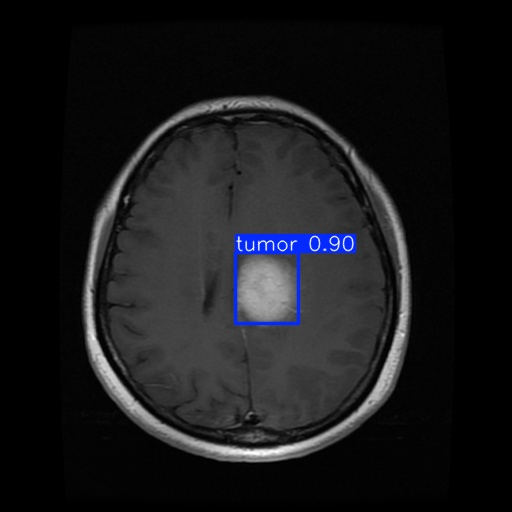

In [23]:
import os
from IPython.display import Image, display

img_path = "/content/figshare_yolo/images/val/10.jpg"  # change file name

single_result = best_model.predict(
    source=img_path,
    imgsz=512,
    conf=0.25,
    save=True,
    project="runs/detect",
    name="single_pred",
    exist_ok=True
)

# Extract the base filename from the input image path
base_filename = os.path.basename(img_path)
# Construct the full path to the saved predicted image
predicted_image_path = os.path.join("runs/detect/single_pred", base_filename)

display(Image(filename=predicted_image_path))
